## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score

plt.style.use("seaborn-v0_8")

### load  both datasets

In [2]:
FRAUD_BALANCED_PATH = "../data/processed/fraud_train_fe.csv"
FRAUD_TEST_PATH = "../data/processed/fraud_test_fe.csv"

CC_BALANCED_PATH = "../data/processed/creditcard_train_fe.csv"
CC_TEST_PATH = "../data/processed/creditcard_test_fe.csv"

MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)

TARGET = "class"

### Helper Functions

In [3]:
def train_and_evaluate(X_train, y_train, X_test, y_test, dataset_name):

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

### Logistic Regression

In [4]:
def train_and_evaluate(X_train, y_train, X_test, y_test, dataset_name):

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Logistic Regression
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)

    y_pred_lr = lr.predict(X_test)
    y_prob_lr = lr.predict_proba(X_test)[:,1]

    lr_f1 = f1_score(y_test, y_pred_lr)
    lr_auc = average_precision_score(y_test, y_prob_lr)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred_rf = rf.predict(X_test)
    y_prob_rf = rf.predict_proba(X_test)[:,1]

    rf_f1 = f1_score(y_test, y_pred_rf)
    rf_auc = average_precision_score(y_test, y_prob_rf)

    print(f"\n===== {dataset_name.upper()} RESULTS =====")
    print("Logistic F1:", lr_f1)
    print("RF F1:", rf_f1)
    print("Logistic AUC-PR:", lr_auc)
    print("RF AUC-PR:", rf_auc)

    # Create models folder outside notebook
    MODEL_DIR = os.path.join("..", "models")
    os.makedirs(MODEL_DIR, exist_ok=True)

    # Save models
    joblib.dump(lr, os.path.join(MODEL_DIR, f"{dataset_name}_logreg.pkl"))
    joblib.dump(rf, os.path.join(MODEL_DIR, f"{dataset_name}_rf.pkl"))
    joblib.dump(scaler, os.path.join(MODEL_DIR, f"{dataset_name}_scaler.pkl"))

    return lr_f1, rf_f1, lr_auc, rf_auc

### PART A — FRAUD DATASET

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve

fraud_train = pd.read_csv(FRAUD_BALANCED_PATH)
fraud_test = pd.read_csv(FRAUD_TEST_PATH)

X_train_fraud = fraud_train.drop(columns=[TARGET])
y_train_fraud = fraud_train[TARGET]

X_test_fraud = fraud_test.drop(columns=[TARGET])
y_test_fraud = fraud_test[TARGET]

print("\nFraud Train Distribution:")
print(y_train_fraud.value_counts())

fraud_scores = train_and_evaluate(
    X_train_fraud,
    y_train_fraud,
    X_test_fraud,
    y_test_fraud,
    "fraud"
)



Fraud Train Distribution:
class
0    95872
1    95872
Name: count, dtype: int64

===== FRAUD RESULTS =====
Logistic F1: 0.2775854000935891
RF F1: 0.6856202304354332
Logistic AUC-PR: 0.39813428536304646
RF AUC-PR: 0.6262034696079143


### PART B — CREDIT CARD DATASET

In [6]:
CC_TARGET = "Class"   # capital C

cc_train = pd.read_csv(CC_BALANCED_PATH)
cc_test = pd.read_csv(CC_TEST_PATH)

# Split features and target
X_train_cc = cc_train.drop(columns=[CC_TARGET])
y_train_cc = cc_train[CC_TARGET]

X_test_cc = cc_test.drop(columns=[CC_TARGET])
y_test_cc = cc_test[CC_TARGET]

print("\nCredit Card Train Distribution:")
print(y_train_cc.value_counts())

# Train + evaluate
cc_scores = train_and_evaluate(
    X_train_cc,
    y_train_cc,
    X_test_cc,
    y_test_cc,
    "creditcard"
)



Credit Card Train Distribution:
Class
0    198277
1    198277
Name: count, dtype: int64

===== CREDITCARD RESULTS =====
Logistic F1: 0.09383080901366826
RF F1: 0.833976833976834
Logistic AUC-PR: 0.6907724552194926
RF AUC-PR: 0.8071297087213506


### FINAL MODEL COMPARISON


========== FINAL RESULTS ==========
       Dataset     LR_F1     RF_F1  LR_AUC_PR  RF_AUC_PR
0        Fraud  0.277585  0.685620   0.398134   0.626203
1  Credit Card  0.093831  0.833977   0.690772   0.807130


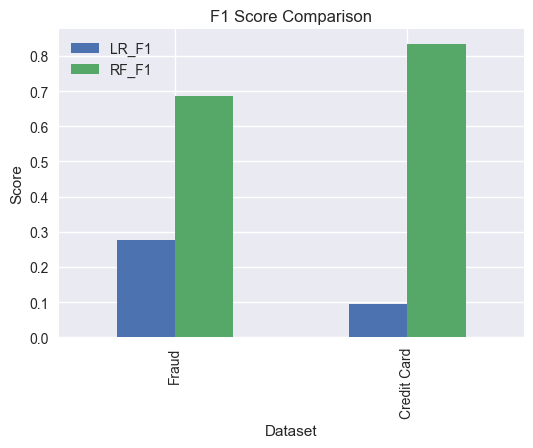

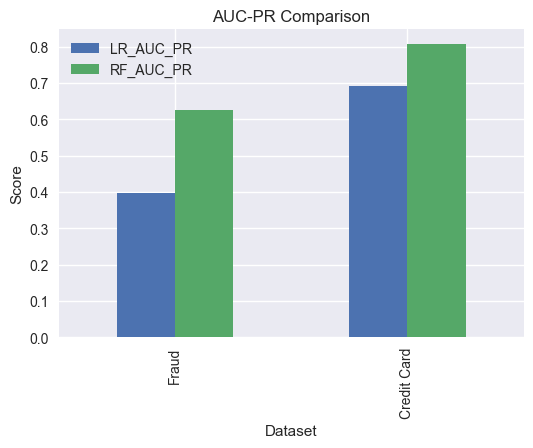

In [7]:
results = pd.DataFrame({
    "Dataset": ["Fraud", "Credit Card"],
    "LR_F1": [fraud_scores[0], cc_scores[0]],
    "RF_F1": [fraud_scores[1], cc_scores[1]],
    "LR_AUC_PR": [fraud_scores[2], cc_scores[2]],
    "RF_AUC_PR": [fraud_scores[3], cc_scores[3]]
})

print("\n========== FINAL RESULTS ==========")
print(results)

# Bar Plot Comparison
results.set_index("Dataset")[["LR_F1","RF_F1"]].plot(kind="bar", figsize=(6,4))
plt.title("F1 Score Comparison")
plt.ylabel("Score")
plt.show()

results.set_index("Dataset")[["LR_AUC_PR","RF_AUC_PR"]].plot(kind="bar", figsize=(6,4))
plt.title("AUC-PR Comparison")
plt.ylabel("Score")
plt.show()